## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import yaml

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
# Import cityscapes
from cityscapes import CityscapesDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
CITYSCAPES_MODEL_PATH = os.path.join(MODEL_DIR, "cityscapes20180626T1016/mask_rcnn_cityscapes_0018.h5")

## Configurations

In [5]:
# Run one of the code blocks
class InferenceConfig(Config):
    """Configuration for inferencing on the cityscapes dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "cityscapes"

    # Backbone network architecture
    # Supported values are: resnet50, resnet101, mobilenet_v1
    BACKBONE = "resnet101"
    # set mobilenet alpha, rows and depth_multiplyer
    if BACKBONE == "mobilenet_v1":
        ALPHA = 1.0
        ROWS = 224
        DEP_MUL = 1

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background + 7 classes

    # set dataset config
    WIDTH = 2048
    HEIGHT = 1024

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

    # Whether add depth features
    ADD_DEPTH = False
    if ADD_DEPTH:
        MEAN_DISPARITY = np.array([7533.725])
        # disparity_fine 7530.4114081432435
        # disparity_coarse 7534.217726138363
        # disparity_extra 7533.724787080577

    # Class Names
    CLASS_NAMES = ['BG', 'person', 'rider', 'car',
                   'truck', 'bus', 'motorcycle', 'bicycle']

In [6]:
# Override the training configurations with a few
# changes for inferencing.

config = InferenceConfig()
config.display()


Configurations:
ADD_DEPTH                      False
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['BG', 'person', 'rider', 'car', 'truck', 'bus', 'motorcycle', 'bicycle']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
HEIGHT                         1024
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrc

## Notebook Preferences

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [9]:
# Build validation dataset
class InferenceDataset(CityscapesDataset):

    def load_cityscapes(self, height, width, filesImages):

        # Add classes
        self.add_class("cityscapes", 1, "person")
        self.add_class("cityscapes", 2, "rider")
        self.add_class("cityscapes", 3, "car")
        self.add_class("cityscapes", 4, "truck")
        self.add_class("cityscapes", 5, "bus")
        self.add_class("cityscapes", 6, "motorcycle")
        self.add_class("cityscapes", 7, "bicycle")

        id = 0  # the ids of images

        for image_path in filesImages:
            image_path_list = image_path.split('/')
            # print(image_path_list)
            image_path_list[5] = 'gtFine_test'
            label_path = '/'.join(image_path_list)
            mask_path = label_path.replace("_leftImg8bit.png",
                                           "_gtFine_instanceTrainIds_labelme.png")
            yaml_path = label_path.replace("_leftImg8bit.png",
                                           "_gtFine_instanceLabelmeNames.yaml")
            if config.ADD_DEPTH:
                image_path_list[5] = 'disparity_test'
                diaparity_path_dir = '/'.join(image_path_list)
                disparity_path = diaparity_path_dir.replace("_leftImg8bit.png",
                                                            "_disparity.png")
            # Make sure more than one instance in the image
            with open(yaml_path) as f:
                temp = yaml.load(f.read())
                labels = temp['label_names']
                del labels[0]

            if labels:
                if config.ADD_DEPTH:
                    self.add_image("cityscapes", image_id=id, path=image_path,
                                   width=width, height=height, mask_path=mask_path,
                                   yaml_path=yaml_path, disparity_path = disparity_path)
                else:
                    self.add_image("cityscapes", image_id=id, path=image_path, width=width,
                                   height=height, mask_path=mask_path, yaml_path=yaml_path)

                id = id + 1

            # print("image_path:",image_path)
            # print("mask_path:",mask_path)
            # print("yaml_path:",yaml_path)

        print("number of images:", id)

# Directory of images to run detection on
IMAGE_DIR = '/home/ason/datasets/cityscapes_disparity_test/leftImg8bit_test'
# Search files
IMAGES = os.path.join(IMAGE_DIR, "val", "*", "*_leftImg8bit.png")
images_evaluate = glob.glob(IMAGES)

# Train dataset
dataset = InferenceDataset()
dataset.load_cityscapes(config.HEIGHT, config.WIDTH, images_evaluate)

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

number of images: 3
Images: 3
Classes: ['BG', 'person', 'rider', 'car', 'truck', 'bus', 'motorcycle', 'bicycle']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "cityscapes":
    weights_path = CITYSCAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/ason/tf-Mask_RCNN_depth/logs/cityscapes20180626T1016/mask_rcnn_cityscapes_0018.h5


## Run Detection

image ID: cityscapes.2 (2) 
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
inference runtime : 17.955 s
gt_class_id              shape: (14,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (14, 4)               min:  156.00000  max:  549.00000  int32
gt_mask                  shape: (1024, 1024, 14)      min:    0.00000  max:    1.00000  uint8


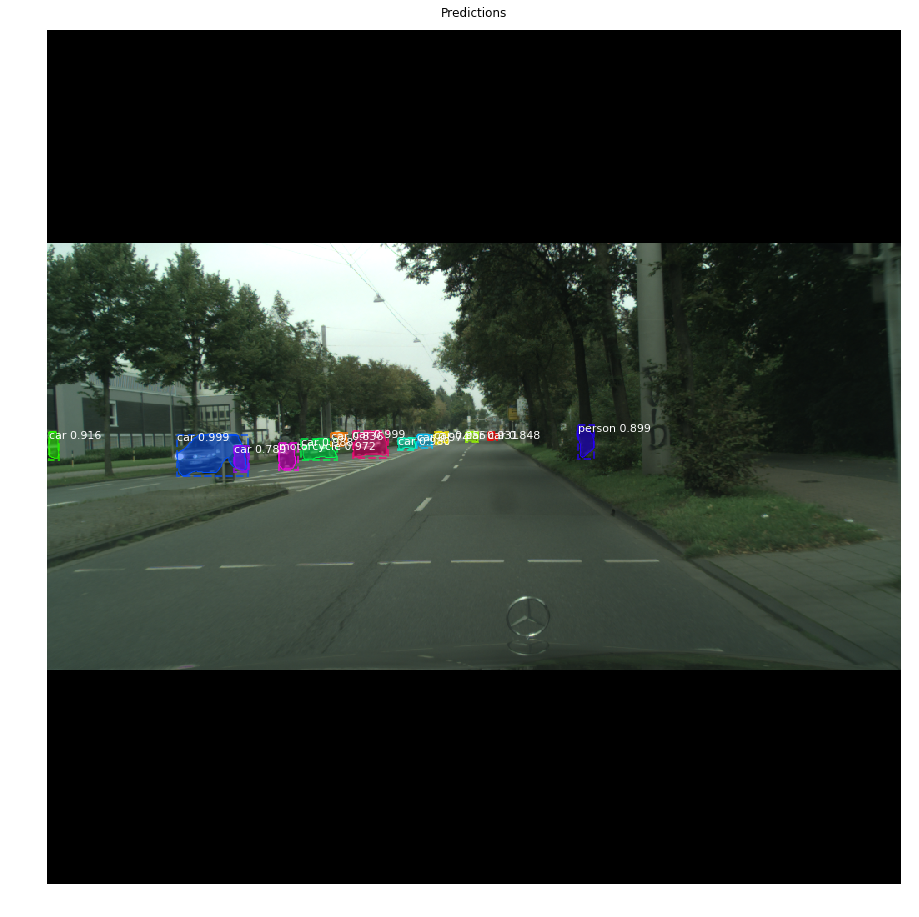

In [12]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run detection and calculate runtime of each image
if config.ADD_DEPTH:
    results, runtime = model.detect_disparity([image], [disparity], verbose=1)
else:
    results, runtime = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

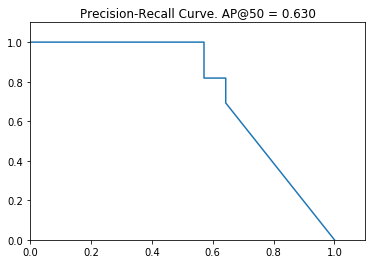

In [13]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

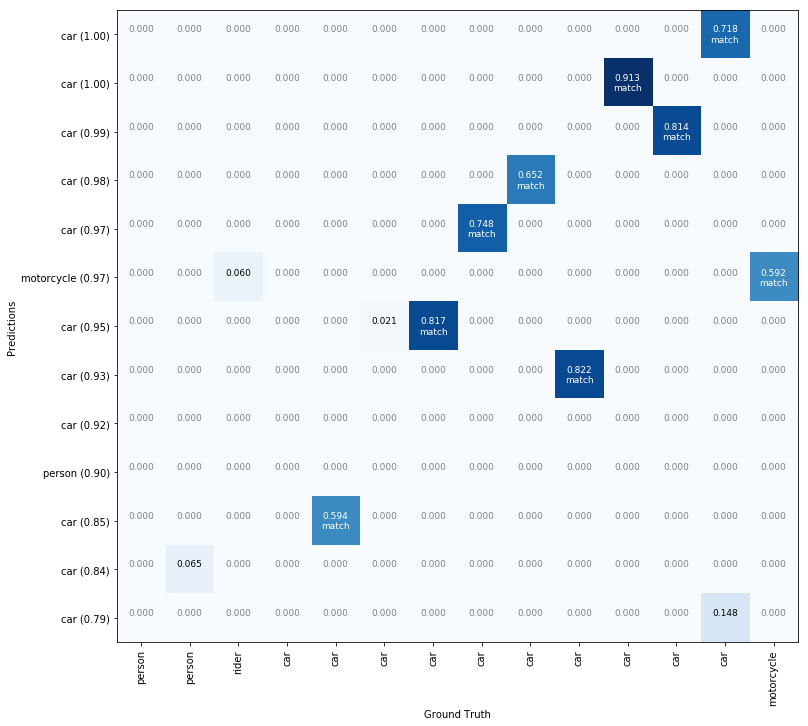

In [14]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [18]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    runtime_list = []
    for image_id in image_ids:
        # Load image
        if config.ADD_DEPTH:
            # Load GT, original image and disparity
            image, image_meta, gt_class_id, gt_bbox, gt_mask, disparity =\
                modellib.load_image_gt_depth(dataset, config,
                                       image_id, use_mini_mask=False)
        else:
            # Load GT and original image
            image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset, config,
                                       image_id, use_mini_mask=False)
        # Run detection and calculate runtime of each image
        if config.ADD_DEPTH:
            results, runtime = model.detect_disparity([image], [disparity], verbose=1)
        else:
            results, runtime = model.detect([image], verbose=1)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
        runtime_list.append(runtime)
    return APs, runtime_list

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 2)
APs, runtime_list = compute_batch_ap(image_ids)
# Calculate and show the avarage runtime
print("inference runtime per image : {:.3f} s".format(np.mean(runtime_list)))
print("mAP @ IoU=50: ", np.mean(APs))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
inference runtime : 18.123 s
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
inference runtime : 18.448 s
inference runtime per image : 18.285 s
mAP @ IoU=50:  0.33417990257342656


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [19]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -6.63701  max:    3.86699  float64
positive_anchors         shape: (34, 4)               min:  146.74517  max:  558.62742  float64
negative_anchors         shape: (222, 4)              min: -106.03867  max: 1194.03867  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (34, 4)               min:  156.00000  max:  539.00000  float32


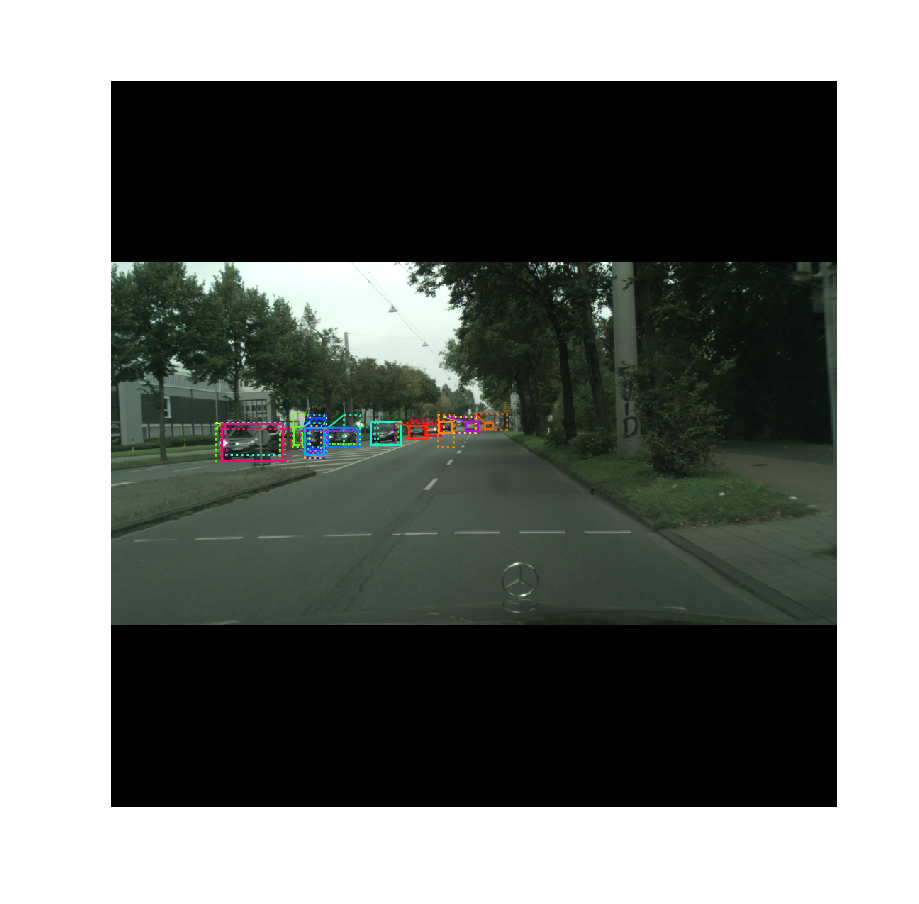

In [20]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [21]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.02212  max:    1.01821  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.01281  max:    1.02967  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 2717.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.67354  float32


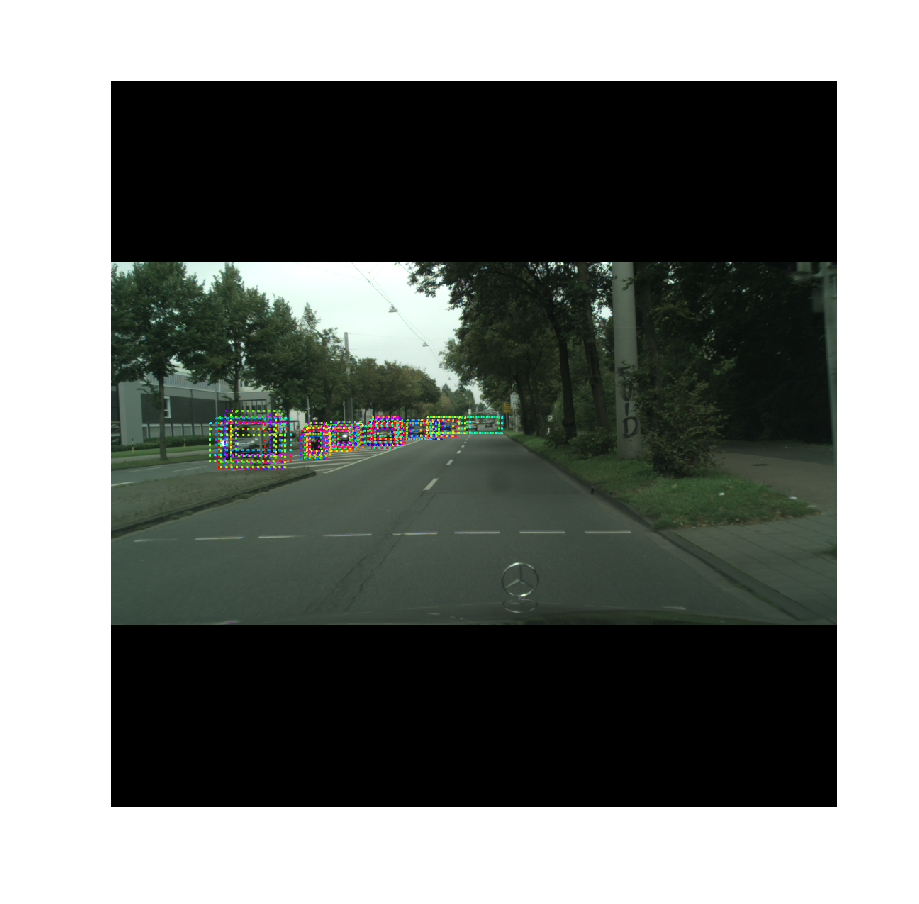

In [22]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

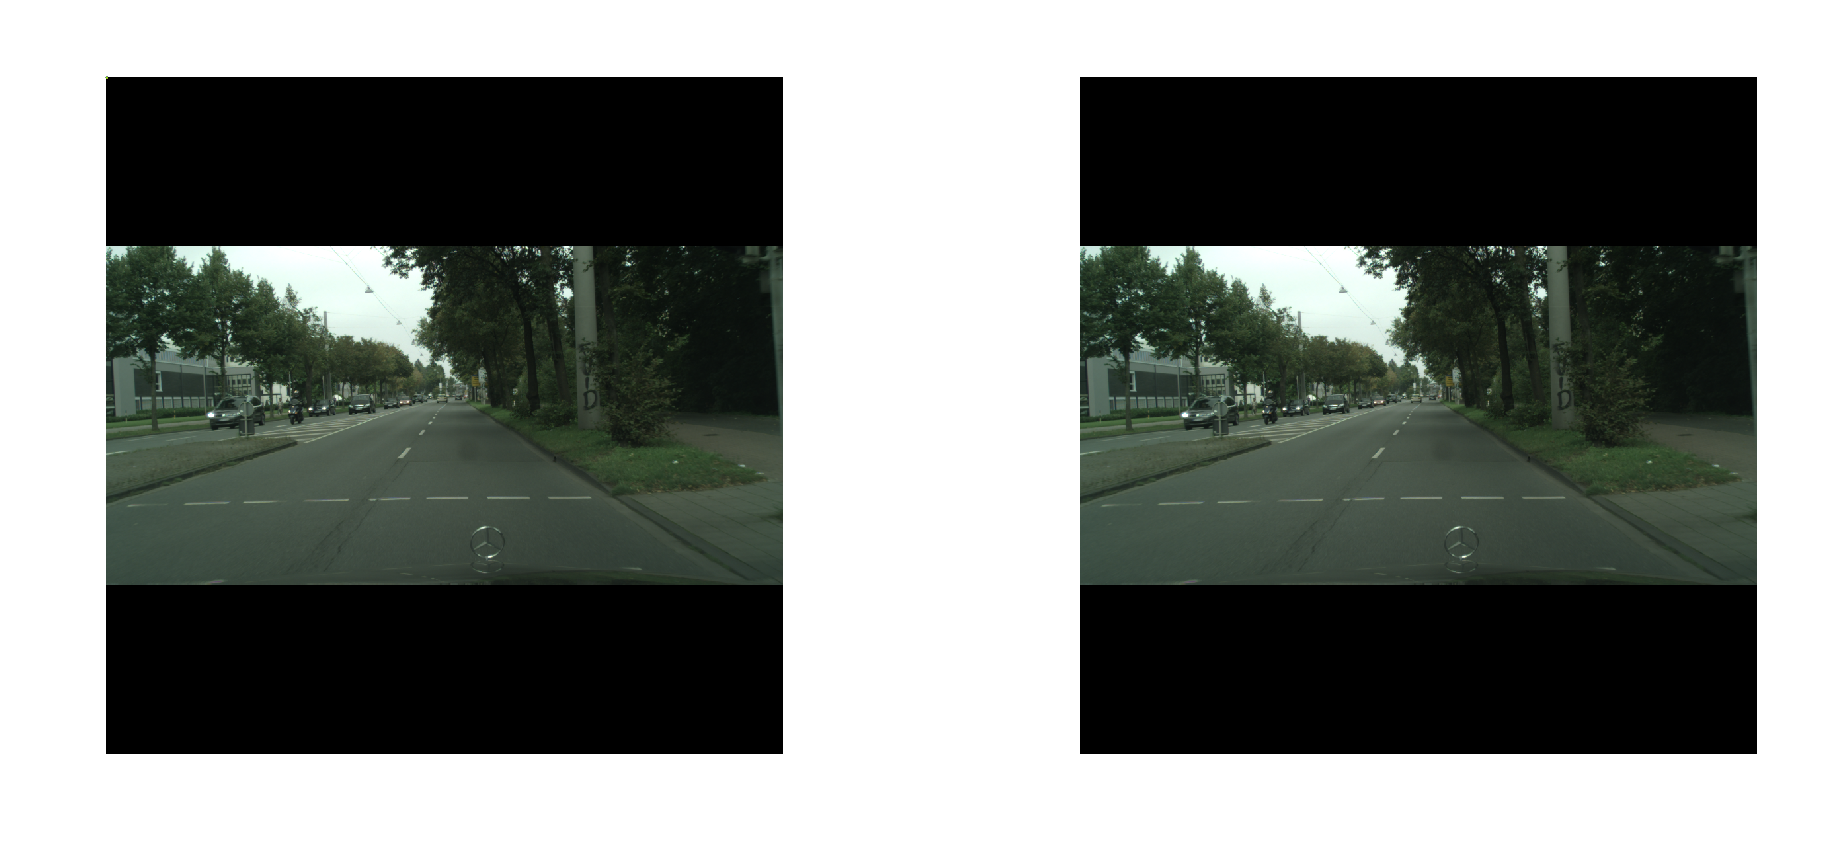

In [23]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

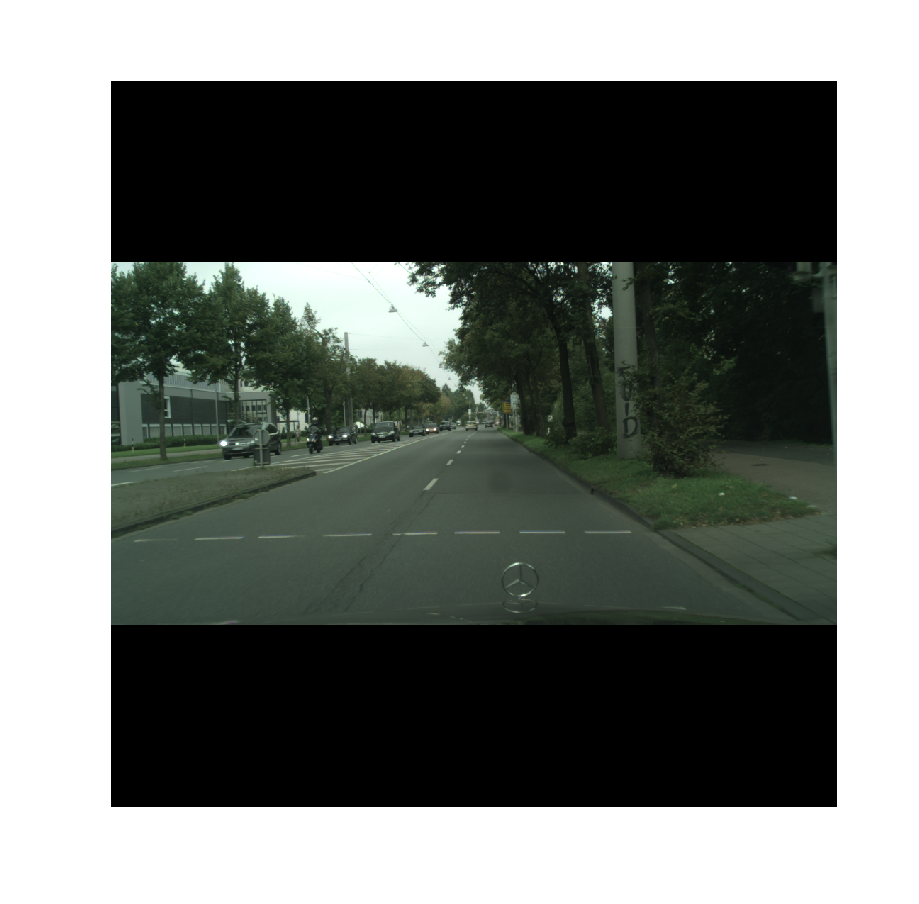

In [24]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

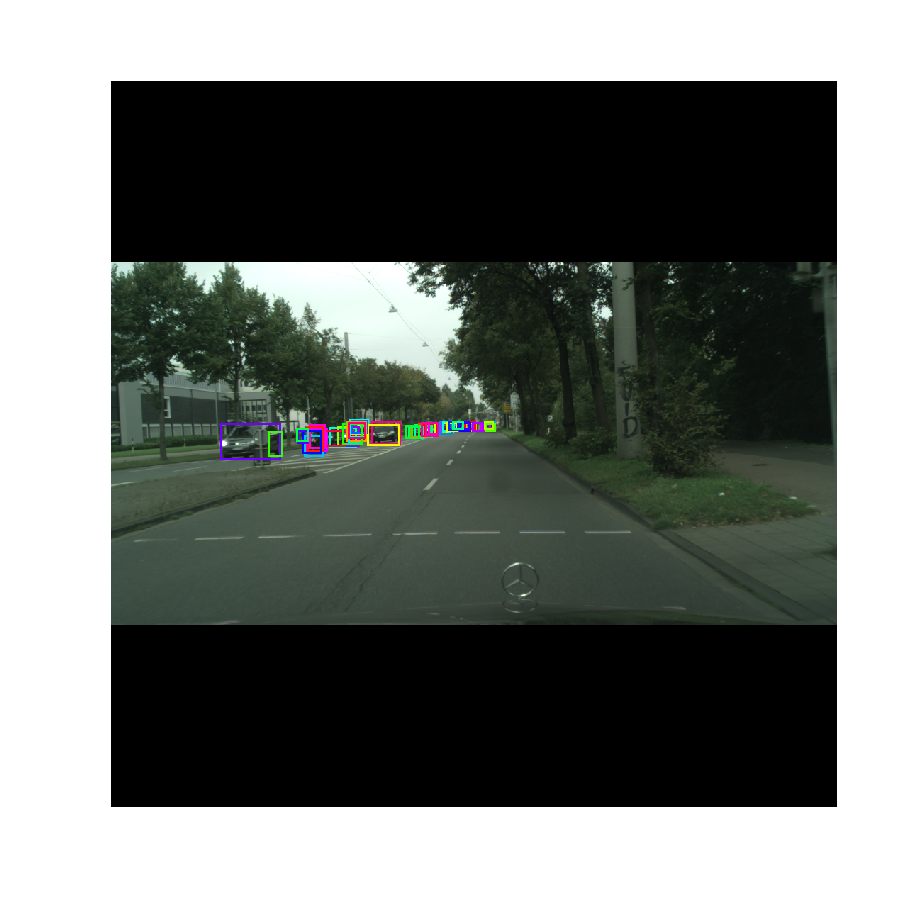

In [25]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [26]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.357  Positive anchors: 26
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 0.643  Positive anchors: 11


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [27]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.67354  float32
probs                    shape: (1, 1000, 8)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 8, 4)       min:   -3.72819  max:    3.58207  float32
masks                    shape: (1, 100, 28, 28, 8)   min:    0.00017  max:    0.99970  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    6.00000  float32


13 detections: ['car' 'car' 'car' 'car' 'car' 'motorcycle' 'car' 'car' 'car' 'person'
 'car' 'car' 'car']


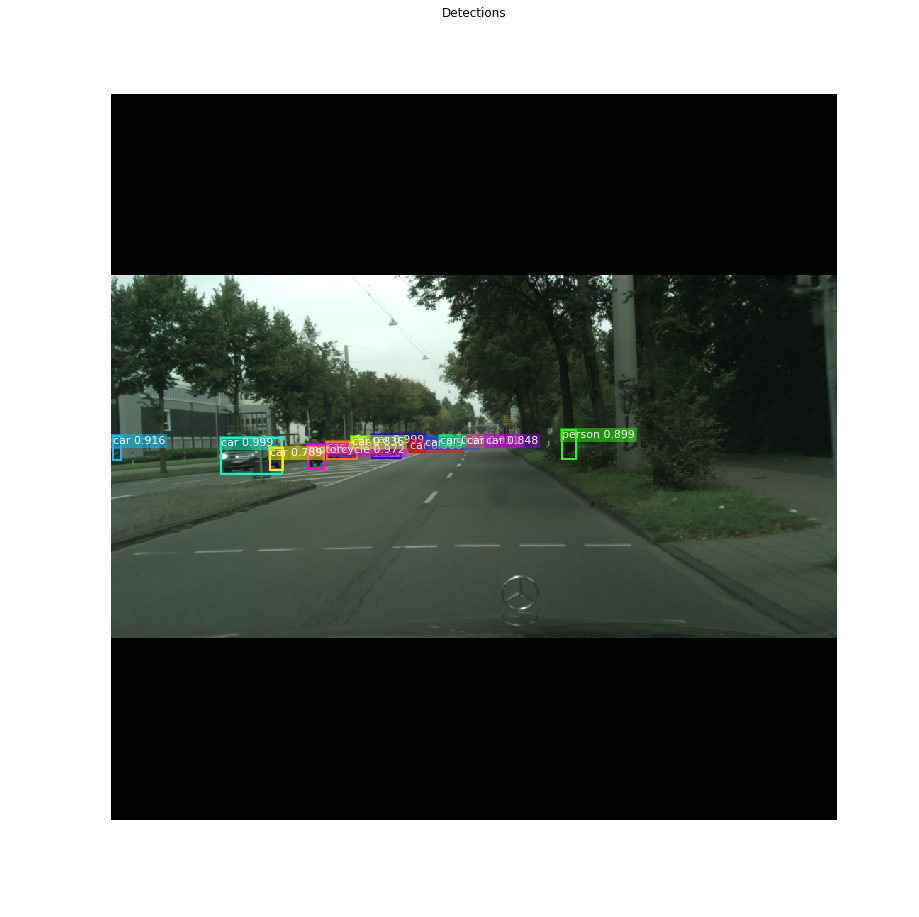

In [28]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [29]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
168 Positive ROIs
[('BG', 832), ('car', 143), ('motorcycle', 16), ('person', 6), ('rider', 3)]


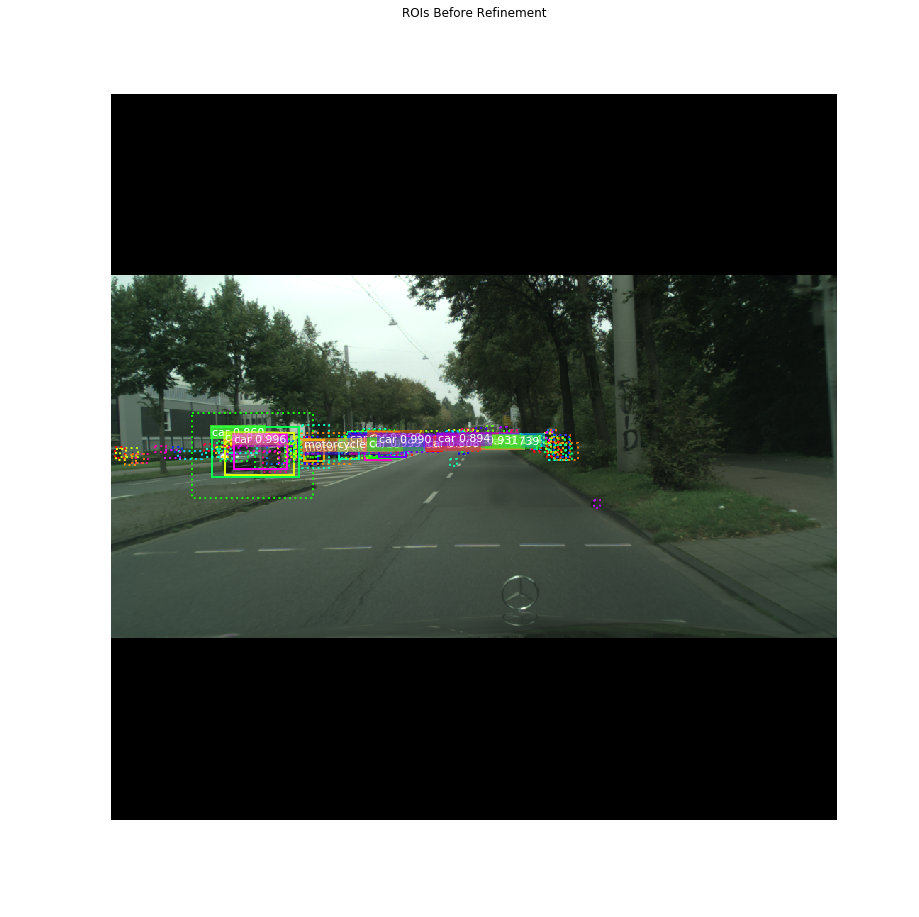

In [30]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.95214  max:    3.58207  float32
refined_proposals        shape: (1000, 4)             min:    0.00000  max:  692.00000  int32


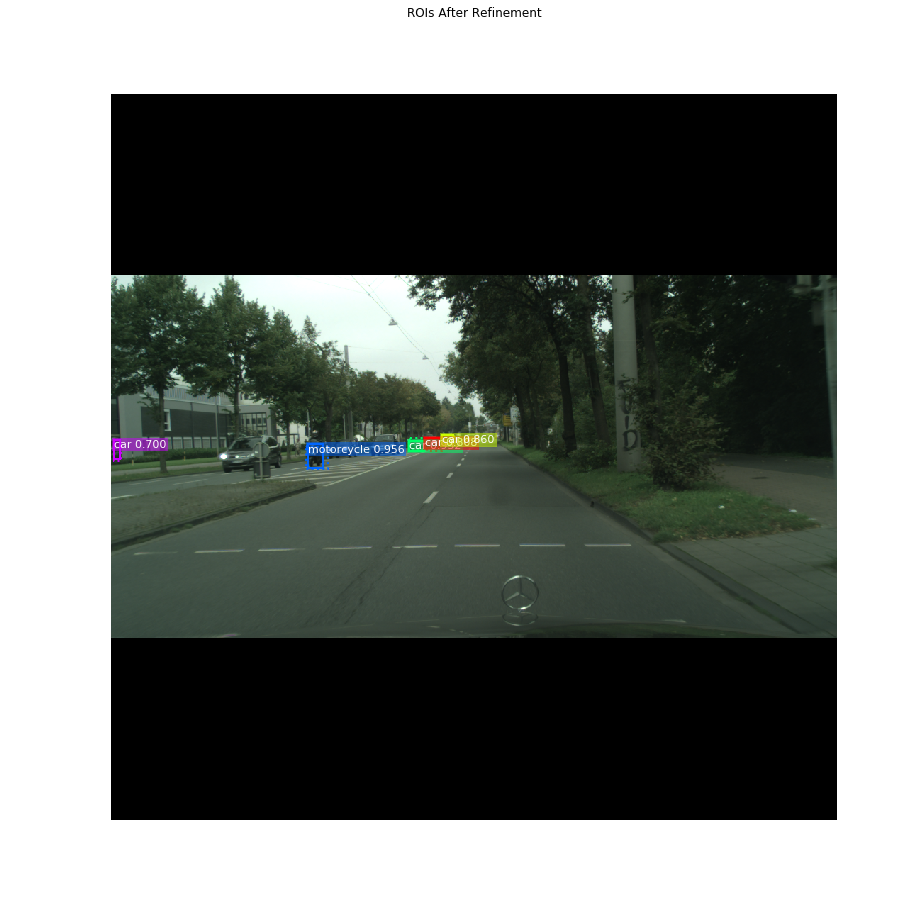

In [31]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [32]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 168 detections:
[  0   1   2   3   5   6   7   8   9  10  11  12  13  15  16  18  19  20
  21  22  23  24  25  26  27  28  30  31  34  35  36  37  38  39  40  41
  44  46  49  53  54  55  56  58  59  62  63  69  71  72  74  79  80  81
  85  88  89  90  91  93  94  96 101 102 103 106 115 116 118 124 126 133
 135 139 143 144 152 155 167 169 170 171 173 176 177 179 182 185 188 192
 197 213 216 219 221 224 226 231 232 233 234 235 241 247 249 251 253 255
 261 262 281 287 297 305 312 318 320 321 324 325 331 334 335 343 345 346
 356 360 363 381 384 390 398 402 404 407 408 415 434 441 460 512 518 561
 569 596 602 660 686 689 690 691 694 699 703 718 725 730 737 747 756 771
 778 812 833 891 894 906]


In [33]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 109:
[  0   1   2   3   5   6   7   8   9  10  11  12  13  16  19  20  21  22
  24  25  26  27  28  30  31  34  35  38  39  40  53  55  56  58  62  63
  69  71  72  81  85  88  89  91  93 102 106 115 116 124 126 133 135 139
 143 152 155 169 170 176 177 182 185 192 197 213 219 221 226 231 232 234
 249 255 261 297 318 331 334 346 356 360 363 381 398 402 404 408 415 460
 512 561 596 602 660 686 689 690 691 694 699 718 725 730 737 747 756 833
 906]


#### Per-Class Non-Max Suppression

In [34]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

person                : [ 85 261 346 398 833] -> [398]
car                   : [  0   1   2   5   6   7   8  10  11  13  16  19  20  21  22  24  25  26
  27  28  30  31  34  35  38  53  55  56  58  62  63  69  72  81  88  89
  93 102 106 115 116 124 126 133 135 139 143 152 155 169 170 176 177 182
 185 192 197 213 219 221 226 231 232 234 249 255 297 318 331 334 356 360
 363 381 402 404 408 415 460 512 561 596 602 660 686 689 690 694 699 718
 725 730 737 747 756 906] -> [  1  24   2   8 133  25  20  81  34 115 331]
motorcycle            : [  3   9  12  39  40  71  91 691] -> [12]

Kept after per-class NMS: 13
[  1   2   8  12  20  24  25  34  81 115 133 331 398]


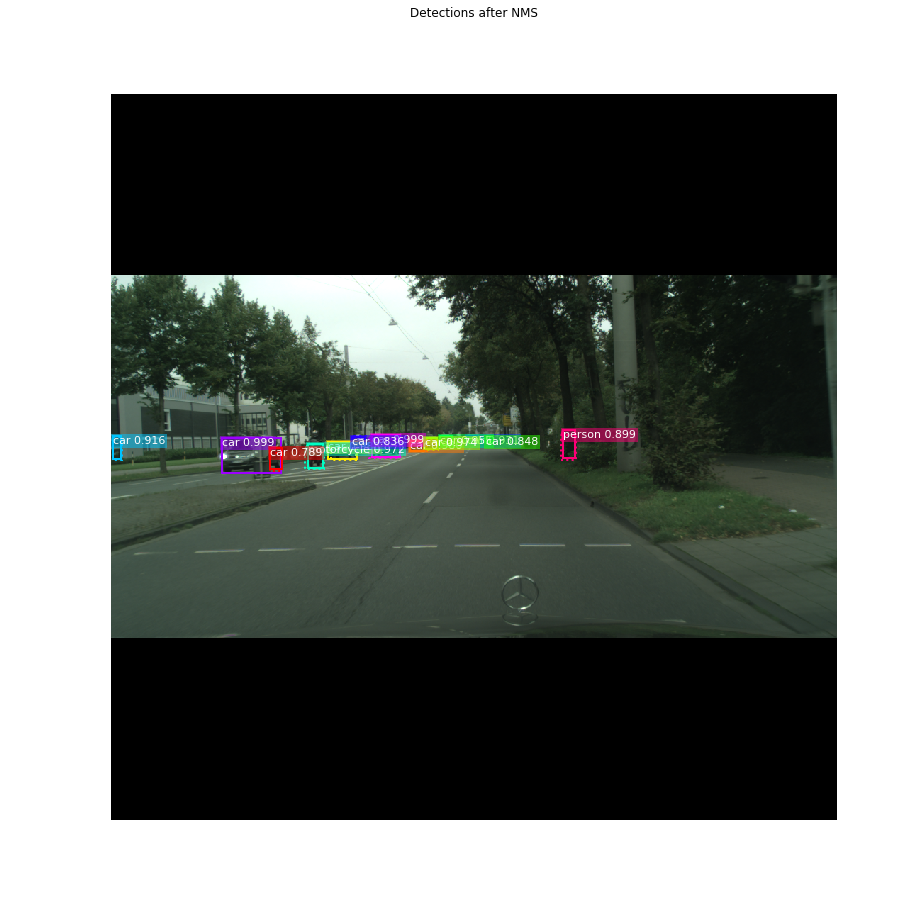

In [35]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

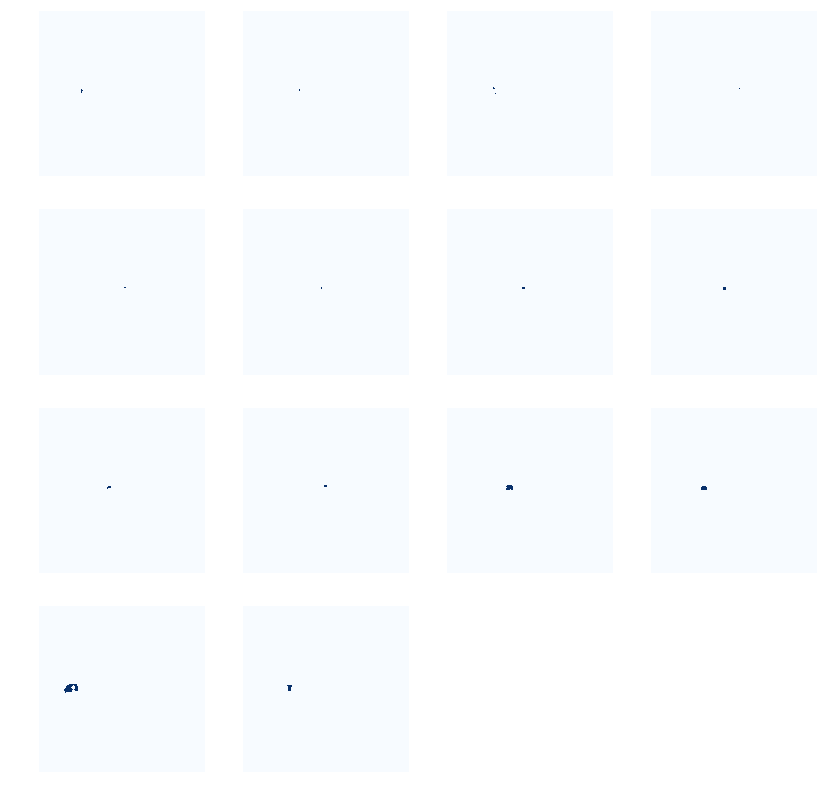

In [36]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [37]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    6.00000  float32
masks                    shape: (1, 100, 28, 28, 8)   min:    0.00017  max:    0.99970  float32
13 detections: ['car' 'car' 'car' 'car' 'car' 'motorcycle' 'car' 'car' 'car' 'person'
 'car' 'car' 'car']


In [38]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (13, 28, 28)          min:    0.00017  max:    0.99970  float32
det_masks                shape: (13, 1024, 1024)      min:    0.00000  max:    1.00000  bool


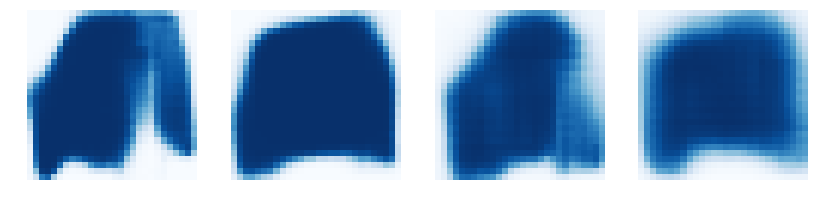

In [39]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

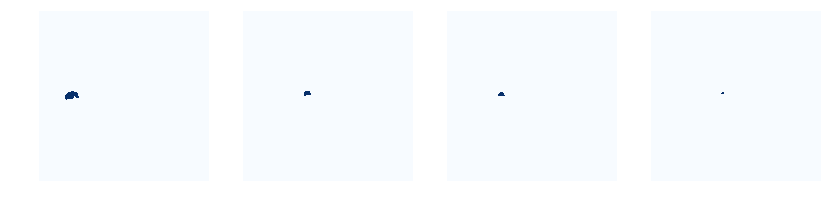

In [40]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [47]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

InvalidArgumentError: input_image:0 is both fed and fetched.

In [43]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

NameError: name 'activations' is not defined

In [44]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

NameError: name 'activations' is not defined

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb45a2694a8>>
Traceback (most recent call last):
  File "/home/ason/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1464, in __del__
    self._session._session, self._handle, status)
  File "/home/ason/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94856604774176
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb45a25eda0>>
Traceback (most recent call last):
  File "/home/ason/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1464, in __del__
    self._session._session, self._handle, status)
  File "/home/ason/anaco

NameError: name 'activations' is not defined

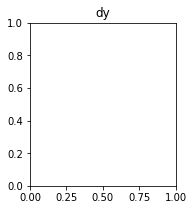

In [45]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

NameError: name 'activations' is not defined

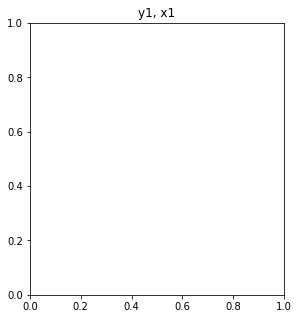

In [46]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()